<a href="https://www.kaggle.com/code/utkarshluv/assignqr?scriptVersionId=230353804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **QR Code Classification with Machine Learning and Deep Learning**

## *Overview*
This project uses machine learning and deep learning techniques to classify QR codes as original or counterfeit.

## **Libraries Used**
- **os, numpy, pandas**: For data manipulation.
- **matplotlib, seaborn**: For visualization.
- **skimage, cv2**: For image processing.
- **sklearn**: For machine learning models.
- **tensorflow, keras**: For deep learning with CNN.






In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, feature, filters, measure
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')


# Ensuring Reproducibility in Machine Learning

- Setting random seeds ensures reproducibility in machine learning experiments.
-  By fixing the seed values for NumPy and TensorFlow, we make sure that operations involving randomness (like weight initialization, data shuffling, and dropout) produce the same results every time the code runs.
  
-   This is crucial for debugging, model comparisons, and research consistency.



In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Loading Dataset for QR Authentication

In this project, we are working with a dataset containing images of QR codes for authentication purposes. The dataset is organized into two categories: 'First Print' and 'Second Print'. To facilitate processing, we load images from these directories and assign labels accordingly.

- **First Print (Label 0):** Represents the first printed version of the QR codes.
- **Second Print (Label 1):** Represents the second printed version of the QR codes.

The dataset is loaded using a function that reads images from the given directory, stores them in a list, and assigns the corresponding label. A limit can be set on the number of images loaded using a parameter to control dataset size.



In [3]:
# Load dataset paths
dataset_dir = '/kaggle/input/qr-auth/Assignment Data/'
first_prints_dir = os.path.join(dataset_dir, 'First Print')
second_prints_dir = os.path.join(dataset_dir, 'Second Print')

# Function to load images
def load_images(directory, label, max_samples=None):
    images = []
    labels = []
    files = os.listdir(directory)[:max_samples]
    for file in files:
        img_path = os.path.join(directory, file)
        img = io.imread(img_path)
        images.append(img)
        labels.append(label)
    return images, labels

# Load images (adjust max_samples as needed)
first_print_imgs, first_print_labels = load_images(first_prints_dir, 0, 200)
second_print_imgs, second_print_labels = load_images(second_prints_dir, 1, 200)

# Feature Extraction for QR Authentication

Feature extraction is a crucial step in processing QR code images for authentication. It helps in transforming raw image data into meaningful numerical representations that can be used for analysis and classification.

### Process Overview

The feature extraction function takes a list of images and computes various statistical and structural properties. These include:

- **Grayscale Conversion:** If the image is in RGB or RGBA format, it is first converted to grayscale to simplify processing.
- **Statistical Features:** Mean, standard deviation, and median intensity values are extracted to capture brightness and contrast variations.
- **Edge Detection:** The Canny edge detector is used to measure edge density, which helps in identifying QR code patterns.
- **Blur Measurement:** Laplacian variance is computed to assess the sharpness of the image.
- **Local Binary Pattern (LBP) Histogram:** LBP is used for texture analysis, and a histogram of LBP values is included as a feature.

The extracted features form a numerical representation of each image, which can be used for further machine learning or deep learning tasks.



In [4]:
# Feature extraction function
def extract_features(images):
    features = []
    for img in images:
        # Convert to grayscale, handling different input formats
        if len(img.shape) == 3:
            if img.shape[2] == 4:  # RGBA
                img = color.rgba2rgb(img)  # Convert RGBA to RGB
            img = color.rgb2gray(img)  # Convert RGB to grayscale
        
        # Feature extraction code
        mean_val = np.mean(img)
        std_val = np.std(img)
        median_val = np.median(img)
        edges = feature.canny(img, sigma=1)
        edge_density = np.mean(edges)
        blur_measure = filters.laplace(img).var()
        lbp = feature.local_binary_pattern(img, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
        lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)

        img_features = [mean_val, std_val, median_val, edge_density, blur_measure]
        img_features.extend(lbp_hist)
        features.append(img_features)
    
    return np.array(features)


### Data Preparation

Once the features are extracted, they are combined with labels and split into training and testing sets for model training:

- **Feature Extraction:** Features are extracted separately for 'First Print' and 'Second Print' images.
- **Label Assignment:** First print images are labeled as `0`, while second print images are labeled as `1`.
- **Data Combination:** The extracted features are stacked together, and labels are assigned accordingly.
- **Train-Test Split:** The dataset is split into training and testing sets (80% training, 20% testing) to prepare for model evaluation.


In [5]:
# Extract features for all images
X_first = extract_features(first_print_imgs)
X_second = extract_features(second_print_imgs)

# Combine features and labels
X = np.vstack((X_first, X_second))
y = np.array([0]*len(X_first) + [1]*len(X_second))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation

After preparing the dataset, a machine learning model is trained and evaluated:

- **Traditional ML Pipeline:** A machine learning pipeline is created using StandardScaler for normalization, PCA for dimensionality reduction, and a Random Forest classifier for classification.
- **Training the Model:** The pipeline is fitted on the training data.
- **Model Evaluation:** The model's performance is assessed using classification metrics and a confusion matrix.
- **Feature Importance Analysis:** The importance of features is analyzed using the trained Random Forest model and PCA (Principal Component Analysis).

These steps help ensure that the model effectively distinguishes between the two QR code print categories based on extracted features.


In [6]:
# Traditional ML Pipeline
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=10),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance analysis
rf_model = pipeline.named_steps['randomforestclassifier']
pca = pipeline.named_steps['pca']
pca_feature_importances = rf_model.feature_importances_

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.89      0.94        19

    accuracy                           0.95        40
   macro avg       0.96      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Confusion Matrix:
[[21  0]
 [ 2 17]]


### PCA Component Importance Visualization

To better understand the impact of each principal component, a bar plot is generated to visualize the importance of PCA components. This helps in interpreting how different features contribute to the classification task and optimizing feature selection.

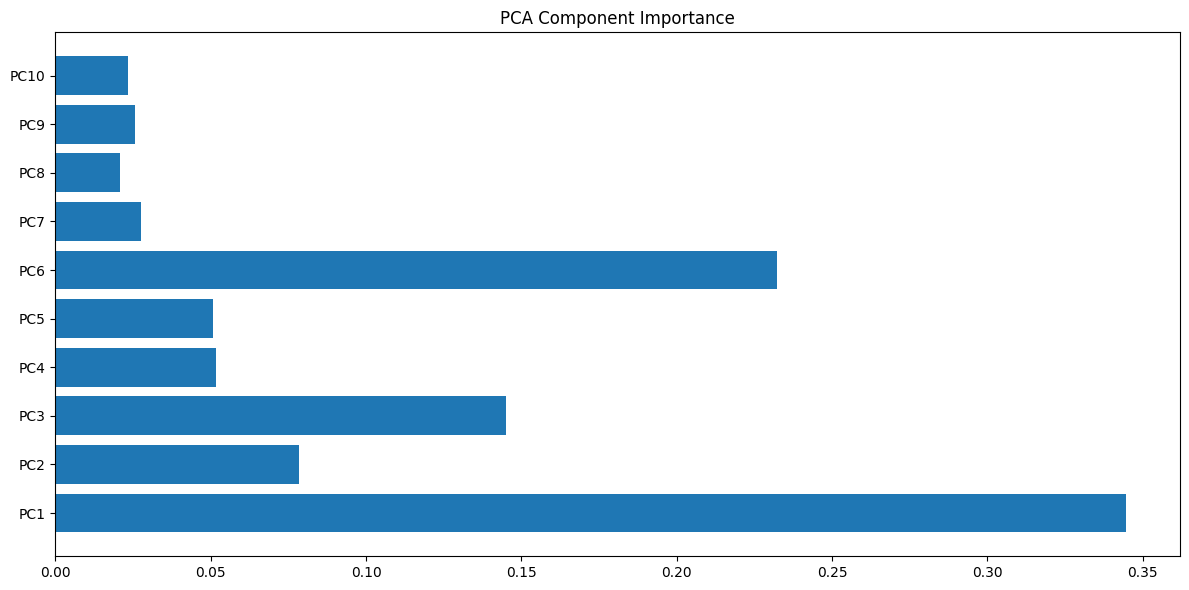

In [7]:
# Plot PCA component importances
plt.figure(figsize=(12, 6))
plt.barh([f'PC{i+1}' for i in range(len(pca_feature_importances))], pca_feature_importances)
plt.title('PCA Component Importance')
plt.tight_layout()
plt.show()

### CNN Image Preparation

Before training the CNN model, the image data must be preprocessed and prepared:

- **Grayscale Conversion:** Images are converted to grayscale to reduce complexity.
- **Resizing:** Images are resized to a standard shape (e.g., 128x128 pixels) for uniform input.
- **Expansion for CNN Compatibility:** A channel dimension is added to fit CNN input requirements.
- **Data Splitting:** The images are split into training and testing sets for model evaluation.


In [8]:
# CNN Approach
def prepare_images(images, target_size=(128, 128)):
    prepared = []
    for img in images:
        if len(img.shape) == 3:
            if img.shape[2] == 4:  # RGBA
                img = color.rgba2rgb(img)
            img = color.rgb2gray(img)
        img_resized = resize(img, target_size, anti_aliasing=True)
        prepared.append(np.expand_dims(img_resized, axis=-1))
    return np.array(prepared)

# Prepare all images
all_images = first_print_imgs + second_print_imgs
X_images = prepare_images(all_images)
y_images = np.array([0]*len(first_print_imgs) + [1]*len(second_print_imgs))

# Split data
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_images, y_images, test_size=0.2, random_state=42
)


### Convolutional Neural Network (CNN) Model

In addition to traditional machine learning approaches, a CNN model is implemented to leverage deep learning for feature extraction and classification:

- **Convolutional Layers:** Three convolutional layers with ReLU activation are used to learn spatial hierarchies of features.
- **Max Pooling:** Pooling layers are applied to reduce dimensionality while retaining important information.
- **Fully Connected Layers:** Flattened feature maps are passed through dense layers for final classification.
- **Dropout Regularization:** A dropout layer is included to prevent overfitting.
- **Binary Classification:** The final dense layer uses a sigmoid activation function to classify images into two categories.
- **Optimization and Loss:** The model is compiled with Adam optimizer and binary cross-entropy loss function for efficient training.

The CNN model enhances feature extraction by learning complex patterns from the images, improving classification accuracy.


In [9]:
# CNN model
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


### CNN Training and Evaluation

Once the CNN model is defined, it undergoes training and evaluation:

- **Model Training:** The CNN model is trained on the extracted image features with labeled data.
- **Evaluation Metrics:** The model is evaluated using accuracy, precision, recall, and F1-score.
- **Confusion Matrix:** A confusion matrix is generated to analyze misclassifications.
- **Prediction Analysis:** Predictions are compared with actual labels to assess performance.

The successful completion of model training and evaluation ensures that the CNN is well-optimized for QR authentication tasks.

In [10]:
# Create and train CNN
cnn_model = create_cnn_model(X_train_img[0].shape)
history = cnn_model.fit(X_train_img, y_train_img, epochs=20, validation_data=(X_test_img, y_test_img), verbose=1)


# Evaluate CNN
y_pred_cnn = (cnn_model.predict(X_test_img) > 0.5).astype(int)
print("\nCNN Performance:")
print(classification_report(y_test_img, y_pred_cnn))
print("Confusion Matrix:")
print(confusion_matrix(y_test_img, y_pred_cnn))


print("\nModel training and evaluation completed successfully.")



Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.4735 - loss: 0.8144 - val_accuracy: 0.4750 - val_loss: 0.6943
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.5339 - loss: 0.6828 - val_accuracy: 0.8250 - val_loss: 0.6726
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.7461 - loss: 0.6580 - val_accuracy: 0.8250 - val_loss: 0.6216
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.7729 - loss: 0.5954 - val_accuracy: 0.9000 - val_loss: 0.5180
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.8311 - loss: 0.4861 - val_accuracy: 0.9000 - val_loss: 0.3582
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.8842 - loss: 0.3569 - val_accuracy: 0.9000 - val_loss: 0.2254
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.8968 - loss: 0.2905 - val_accuracy: 0.9500 - val_loss: 0.1869
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.9240 - loss: 0.2314 - val_accuracy: 0.9500 - val_loss:

### Training History Visualization

To analyze the model's performance during training, a plot of accuracy and loss is generated:

- **Training vs. Validation Accuracy:** A line plot is created to compare the model's accuracy on the training and validation datasets across epochs.
- **Training vs. Validation Loss:** Another line plot visualizes the loss function over training epochs to monitor convergence and overfitting.

The successful completion of model training, evaluation, and visualization ensures that the CNN is well-optimized for QR authentication tasks.


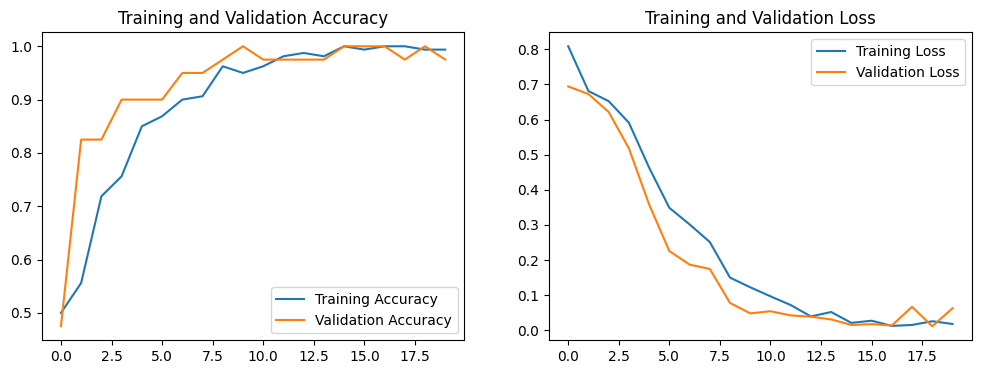

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Deployment Considerations

### Real-World Deployment
Deploying this solution in a real-world setting requires careful consideration of infrastructure, scalability, and accessibility. Cloud-based deployment using platforms like AWS, Google Cloud, or Azure can provide the necessary computational resources while ensuring high availability. Alternatively, edge computing solutions can be explored for real-time processing.

### Computational Efficiency
Optimizing computational efficiency is crucial for real-time performance. Techniques such as model quantization, pruning, and hardware acceleration (e.g., using GPUs or TPUs) can significantly reduce latency. Additionally, batch processing and efficient data pipelines can enhance performance for large-scale applications.

### Robustness to Different Scanning Conditions
The solution must be robust to variations in lighting, angles, noise, and occlusions. Implementing adaptive preprocessing techniques, such as dynamic contrast adjustment and background noise reduction, can improve reliability. Augmenting the training dataset with diverse real-world samples can also enhance model generalization.

### Security Implications
Security is a critical concern when deploying AI-driven solutions. Ensuring secure data transmission through encryption (e.g., TLS/SSL) and implementing proper authentication mechanisms can prevent unauthorized access. Additionally, safeguarding against adversarial attacks and data privacy breaches is essential for maintaining system integrity and user trust.

# Sample Outputs


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color

def predict_and_show_single_image(model, image_path, is_cnn=False, target_size=(128, 128)):
    """
    Predict and display a single QR code image with the prediction result
    
    Parameters:
    model: trained model (either traditional ML pipeline or CNN)
    image_path: path to the image file
    is_cnn: boolean indicating if the model is a CNN
    target_size: target size for CNN input (only used if is_cnn=True)
    """
    # Load the image
    img = io.imread(image_path)
    
    # Prepare the image based on model type
    if is_cnn:
        # CNN processing
        if len(img.shape) == 3:
            if img.shape[2] == 4:  # RGBA
                img = color.rgba2rgb(img)
            elif img.shape[2] == 3:  # RGB
                pass
            else:
                img = img.mean(axis=2, keepdims=True)
        elif len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
            
        img_processed = resize(img, target_size, anti_aliasing=True)
        if img_processed.shape[2] == 3:
            img_processed = np.expand_dims(color.rgb2gray(img_processed), axis=-1)
        img_processed = np.expand_dims(img_processed, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = model.predict(img_processed)[0][0]
        class_idx = int(prediction > 0.5)
        confidence = prediction if class_idx == 1 else 1 - prediction
    else:
        # Traditional ML processing
        if len(img.shape) == 3:
            if img.shape[2] == 4:  # RGBA
                img = color.rgba2rgb(img)
                img = color.rgb2gray(img)
            elif img.shape[2] == 3:  # RGB
                img = color.rgb2gray(img)
            else:
                img = img.mean(axis=2)
                
        # Extract features (same as training)
        mean_val = np.mean(img)
        std_val = np.std(img)
        median_val = np.median(img)
        edges = feature.canny(img, sigma=1)
        edge_density = np.mean(edges)
        glcm = feature.graycomatrix((img * 255).astype(np.uint8), distances=[5], angles=[0], levels=256)
        contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
        energy = feature.graycoprops(glcm, 'energy')[0, 0]
        correlation = feature.graycoprops(glcm, 'correlation')[0, 0]
        blur_measure = filters.laplace(img).var()
        lbp = feature.local_binary_pattern(img, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        high_freq_energy = np.mean(magnitude_spectrum[20:30, 20:30])
        
        features = [
            mean_val, std_val, median_val, edge_density, 
            contrast, dissimilarity, homogeneity, energy, correlation,
            blur_measure, high_freq_energy
        ]
        features.extend(lbp_hist)
        
        # Make prediction
        class_idx = model.predict([features])[0]
        confidence = np.max(model.predict_proba([features]))
    
    # Class labels
    class_names = ['First Print (Original)', 'Second Print (Counterfeit)']
    
    # Create visualization
    plt.figure(figsize=(8, 8))
    
    # Show the image
    plt.subplot(2, 1, 1)
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title('Input QR Code')
    plt.axis('off')
    
    # Show prediction result
    plt.subplot(2, 1, 2)
    plt.text(0.5, 0.6, f'Prediction: {class_names[class_idx]}', 
             fontsize=12, ha='center')
    plt.text(0.5, 0.4, f'Confidence: {confidence:.2%}', 
             fontsize=12, ha='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return class_idx, confidence




# For CNN model:
# predict_and_show_single_image(cnn_model, test_image_path, is_cnn=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


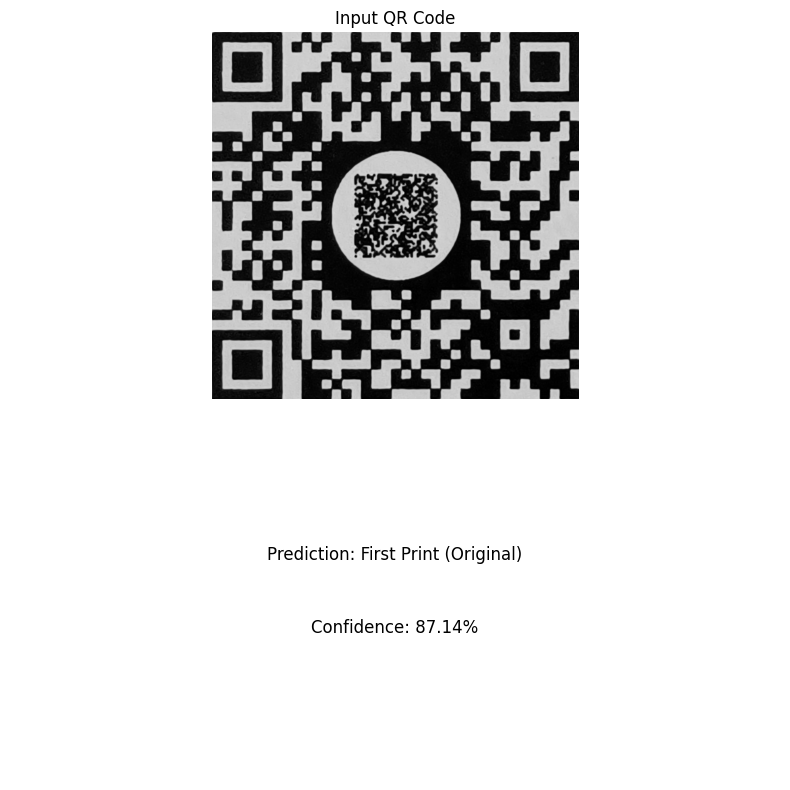

(0, 0.8714459091424942)

In [13]:
test_image_path = '/kaggle/input/qr-auth/Assignment Data/First Print/input_image_active (1).png'
predict_and_show_single_image(cnn_model, test_image_path, is_cnn=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


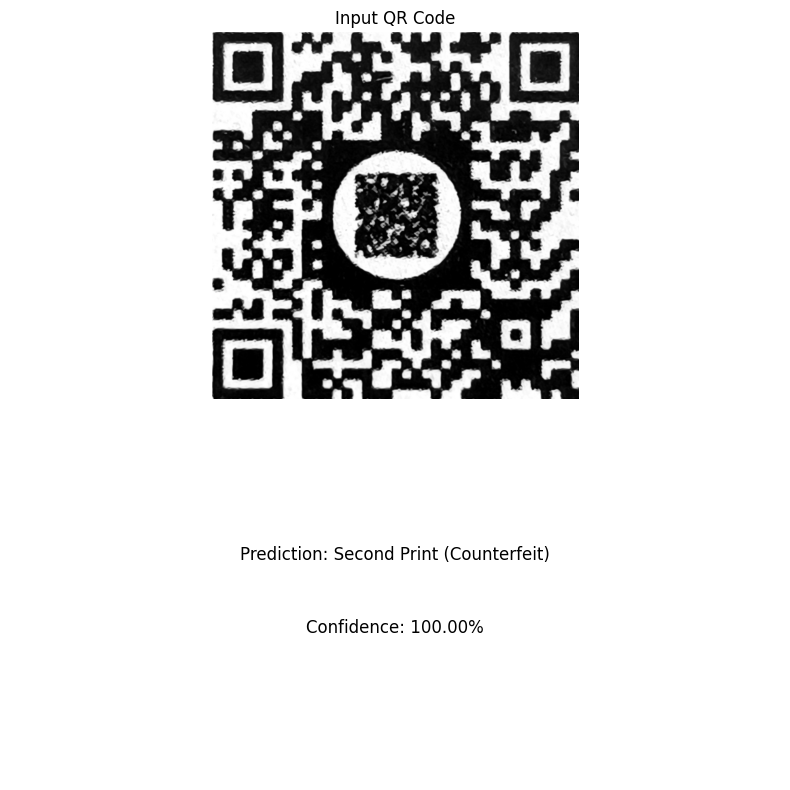

(1, 0.9999995)

In [14]:
test_image_path = '/kaggle/input/qr-auth/Assignment Data/Second Print/input_image_active (3).png'
predict_and_show_single_image(cnn_model, test_image_path, is_cnn=True)